#Racing Line Calculator

In [1]:
# Imports
import geopandas as gpd
import geojsonio
import matplotlib.pyplot as plt
%matplotlib notebook

import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import os.path

import copy

from scipy.interpolate import interp1d
np.seterr(all="ignore")


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Simulation Settings and Data Imports
interp_val = .05
iters = 500

folder = "./circuits"
filename = 'az-2016.geojson'
track = gpd.read_file(folder + '/' + filename)

actual_track_length = 6.003

In [3]:
# Display Track in Browser
#geojsonio.display(track.to_json())

In [4]:
# Extract Center Line Information
track_line = track.geometry[0]
track_line

coords = np.array(track_line.coords)
y_diff_mean = np.mean(np.diff(coords[:,0]))
x_diff_mean = np.mean(np.diff(coords[:,1]))
tot_diff_mean = np.sqrt(y_diff_mean**2 + x_diff_mean**2)

y_list = [coords[0, 1]]
x_list = [coords[0, 0]]

In [5]:
# Interpolate Track and Create Width
for i in range(coords.shape[0]):
    if i > 1:
        x_i_diff = coords[i,0] - coords[i-1,0]
        y_i_diff = coords[i,1] - coords[i-1,1]
        
        tot_i_diff = np.sqrt(x_i_diff**2 + y_i_diff**2)
        
        y_list.append(coords[i,1])
        x_list.append(coords[i,0])
        
        if tot_i_diff > interp_val* tot_diff_mean:
            x_i = coords[i,0]
            x_i1 = coords[i-1,0]
            
            y_i = coords[i,1]
            y_i1 = coords[i-1, 1]
        
            x = interp1d([x_i, x_i1], [y_i, y_i1])
            
            xs = np.linspace(x_i1, x_i, 5)
            
            y = x(xs)
            
            final_x = list(xs)
            final_y = list(y)
            
            for j in range(len(final_x)):
                x_list.append(final_x[j])
                y_list.append(final_y[j])
            
    
new_track_line_data = np.zeros([len(x_list), 2])
new_track_line_data[:, 0] = x_list
new_track_line_data[:, 1] = y_list

new_track_line = LineString(new_track_line_data)

conv = actual_track_length/new_track_line.length


track_poly = new_track_line.buffer(15/conv/10000, resolution = 40)

def extract_poly_coords(geom):
    if geom.type == 'Polygon':
        exterior_coords = geom.exterior.coords[:]
        interior_coords = []
        for interior in geom.interiors:
            interior_coords += interior.coords[:]
    elif geom.type == 'MultiPolygon':
        exterior_coords = []
        interior_coords = []
        for part in geom:
            epc = extract_poly_coords(part)  # Recursive call
            exterior_coords += epc['exterior_coords']
            interior_coords += epc['interior_coords']
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.type))
    return {'exterior_coords': exterior_coords,
            'interior_coords': interior_coords}

coord_dict = extract_poly_coords(track_poly)

center_line = new_track_line_data
inner_border = np.array(coord_dict['interior_coords'])
outer_border = np.array(coord_dict['exterior_coords'])

l_outer_border = LineString(outer_border)
l_inner_border = LineString(inner_border)
l_center_line = LineString(center_line)


road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

In [6]:
# Initialize Plotting Functions (from https://github.com/cdthompson/deepracer-k1999-race-lines)

# MIT License

# Copyright (c) 2019 Christopher D Thompson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='red', zorder=1, markersize=.1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='green', zorder=1, markersize=.1)                               
                                                                                
def plot_line(ax, ob, color):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color=color, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints[:,0:2])                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line, 'cyan')                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line, 'red')                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line, 'red')

In [7]:
# Curvature Function and Improve Race Line Function
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

XI_ITERATIONS=3
LINE_ITERATIONS=iters

# MIT License

# Copyright (c) 2019 Christopher D Thompson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
These should be the same:  ((505, 2), (505, 2))
Original centerline length: 0.19
New race line length: 0.06


<IPython.core.display.Javascript object>


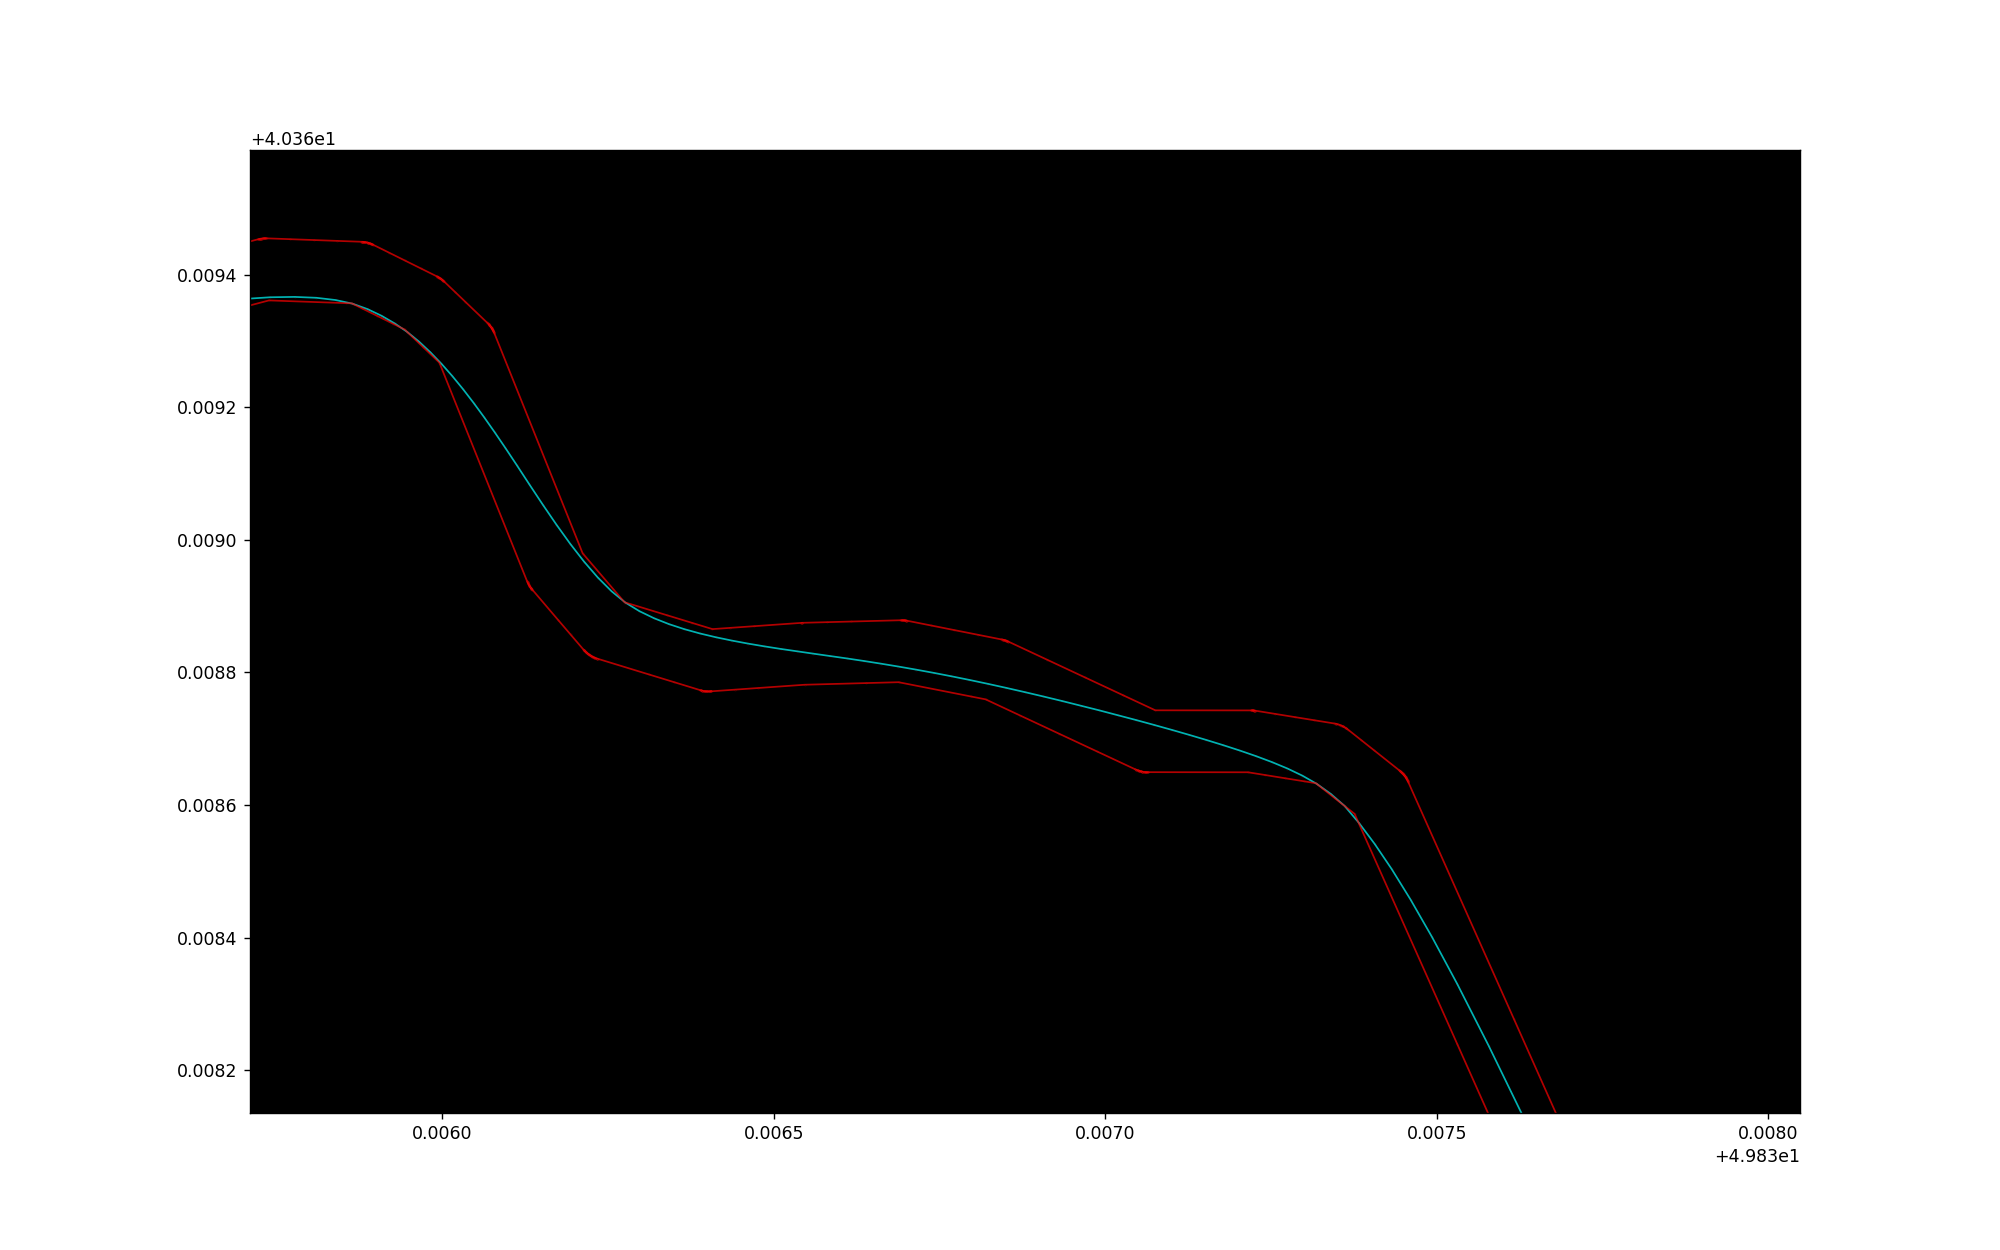

In [8]:
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 50 == 0: print("Iteration %d" % i)
    
    
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)